In [12]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

from sklearn.model_selection import KFold

In [13]:
with open('order_dict.json') as f:
    data = json.load(f)

In [14]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [15]:
order_dict[1]

,demand,day_of_week,order_hour_mode,order_hour_08,order_hour_95,att1_high,att1_miss,att2_high,att2_miss,type_1_percent,...,fast_promise,original_unit_price_mean,discount_rate_mean,direct_discount_rate_mean,quantity_discount_rate_mean,bundle_discount_mean,gift_mean,dc_ori_mode,dc_ori_num,cluster_id
day_of_month,,,,,,,,,,,,,,,,,,,,,
1,5,3,12,0.000000,1.000000,0.750000,0.250000,0.000000,0.750000,0.000000,...,0.250000,121.475000,0.070538,0.061069,0.009470,0.000000,0.000000,7,1,0
1,18,3,5,0.444444,0.555556,1.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,7,1,1
1,57,3,23,0.111111,0.400000,0.488889,0.222222,0.333333,0.355556,0.933333,...,0.888889,108.322222,0.468941,0.104816,0.238231,0.000000,0.044444,7,3,2
1,11,3,14,0.090909,0.636364,1.000000,0.000000,0.545455,0.090909,0.090909,...,0.272727,144.081818,0.669827,0.568953,0.027548,0.000000,0.000000,7,1,3
1,58,3,12,0.111111,0.416667,0.777778,0.083333,0.500000,0.111111,0.333333,...,0.472222,125.488889,0.421472,0.170375,0.178280,0.000000,0.000000,7,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,39,5,14,0.028571,0.742857,0.400000,0.342857,0.628571,0.057143,0.057143,...,0.171429,104.162857,0.335590,0.118868,0.003852,0.013378,0.028571,7,2,6
31,16,5,15,0.000000,0.866667,0.733333,0.200000,0.533333,0.200000,0.000000,...,0.000000,1.200000,0.933333,0.000000,0.000000,0.000000,0.933333,7,1,7
31,26,5,13,0.090909,0.636364,0.590909,0.272727,0.454545,0.272727,0.727273,...,0.727273,111.381818,0.412384,0.084126,NaN,0.039330,0.272727,1,3,8


In [16]:
final_result = dict()

In [17]:
def preprocessing(df_i):
    
    df = df_i.copy()
    df = df.fillna(0)
    df.replace(np.inf,0, inplace = True)

    # convert data type for categorical features
    df['cluster_id'] = df['cluster_id'].astype('object')
    df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
    df['day_of_week'] = df['day_of_week'].astype('object')

    cat = ['cluster_id','dc_ori_mode','day_of_week']
    num = df.drop(cat+['demand'], axis = 1).columns
    #print(num)
    
    
    # train test split
    df_enc = pd.get_dummies(df, columns = cat, drop_first = True)
    train_enc = df_enc.query('1<= day_of_month <= 24')
    test_enc = df_enc.query('24 < day_of_month <= 31')

    # train = df.query('1<= day_of_month <= 24')
    # test = df.query('24 < day_of_month <= 31')

    # train_enc = pd.get_dummies(train, columns = cat, drop_first = True)
    # test_enc = pd.get_dummies(test, columns = cat)

    # print(train_enc.dtypes)
    # print(test_enc.dtypes)

    # standardize data
    scaler = StandardScaler()

    # x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
    # x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]

    x_train = train_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1).to_numpy() # only remove highest vif column
    x_train = scaler.fit_transform(x_train)

    y_train = train_enc['demand'].to_numpy().reshape(len(train_enc), 1)


    x_test = test_enc.drop(['demand', 'discount_rate_mean','type_1_percent'], axis = 1) 
    x_test = scaler.fit_transform(x_test)

    y_test = test_enc['demand'].to_numpy().reshape(len(test_enc), 1)
    
    #print(x_train.shape, y_train.shape)
    #print(x_test.shape, y_test.shape)

    return x_train, y_train, x_test, y_test

In [18]:
def r2_loss(outputs, targets):
    target_mean = torch.mean(targets)
    ss_tot = torch.sum((targets - target_mean) ** 2)
    ss_res = torch.sum((targets - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def r2_loss_2(outputs, targets):
    ss_tot = 0.0
    ss_res = 0.0
    target_mean = torch.mean(targets)
    for i in range(0,len(outputs)):
        ss_tot += (targets[i] - target_mean) ** 2
        ss_res += (targets[i] - outputs[i]) ** 2
    r2 = 1 - ss_res / ss_tot
    return r2

# TODO: need to work with tensor objects.
def SPOLoss (d_pred, d_actual):
    # W: items to stock the warehouse
    # h: inventory cost
    # s: shipping cost
    # ci: capacity limit for warehouse i = 1000 (per month)
    cost = 0.0
    max_capacity = 1000.0 / 31
    for i in range(0, len(d_pred)):
        if d_pred[i] <= max_capacity:
            w = d_pred[i]
        else:
            w = max_capacity
        if w > d_actual[i]:
            h = 2.920 * (w - d_actual[i])  # average inventory cost per sku * (w - target)
            s = 0
        else:
            h = 0
            s = 0.803 * (d_actual[i] - w)
        cost += h + s
    return cost
 
# print(torch.Tensor.float(1.0))
outputs = torch.randn(5)
targets = torch.randn(5)
# print(outputs.size())
# for i in range(0,len(outputs)):
#   print(2)
print(r2_loss(outputs,targets))
print(r2_loss_2(outputs,targets))
print(SPOLoss(outputs,targets))
# print(torch.randn(5))
# print(SPOLoss(1, 2))

tensor(0.1249)
tensor(0.1249)
tensor(11.4017)


In [19]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [20]:
# define training and evaluation functions

def predict(model, x):
    
    """
    takes in a pytorch model and a matrix of features
    return a list of predictions
    """
    
    with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
        pred_y = model(Variable(torch.from_numpy(x).float())).data.numpy()
        pred_y = [pred_y[x].item() for x in range(len(pred_y))]
    return pred_y

def linearRegressionTrain(x_train, y_train, learningRate, epochs, loss_type = 'MSE', regularize = 'None', l1_penalty = 0, l2_penalty = 0, plot = True, verbose = True):
    """
    input: 
        - x_train whose type is numpy.ndarray
        - y_train whose type is numpy.ndarray
        - learningRate
        - epochs
        - regularization can be either "None" or "l1" or "l2", default is none
        - loss_type can be either "MSE" or "SPO", default is 'MSE'
        - plot: whether you want to plot the loss against epochs, default is True
        
    output:
        trained pytorch linear regression model
    """
    _, inputDim = x_train.shape
    outputDim = 1       # takes variable 'y'
    
    loss_list = []

    model = linearRegression(inputDim, outputDim)
    
    ##### For GPU #######
    # if torch.cuda.is_available():
    #     model.cuda()
    
    # initialize the loss function and optimizer
    if loss_type == 'MSE': 
        
        criterion = torch.nn.MSELoss()  
        # criterion = r2_loss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.SGD(model.parameters(),weight_decay = l2_penalty, lr=learningRate)
            
    elif loss_type == 'SPO': # change loss function and switch to adam optimizer
        
        criterion = SPOLoss
        
        if regularize == 'None' or regularize == 'l1':
            optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
        else: # regularize = 'l2'
            optimizer = torch.optim.Adam(model.parameters(),weight_decay = l2_penalty, lr=learningRate)

    else:
        raise Exception('wrong loss_type')
        
    # model training

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        # if torch.cuda.is_available():
        #     inputs = Variable(torch.from_numpy(x_train).cuda())
        #     labels = Variable(torch.from_numpy(y_train).cuda())
        # else:
        #     inputs = Variable(torch.from_numpy(x_train))
        #     labels = Variable(torch.from_numpy(y_train))
        inputs = Variable(torch.from_numpy(x_train))
        labels = Variable(torch.from_numpy(y_train))

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs.type(torch.FloatTensor))

        # get loss for the predicted output
        loss = criterion(outputs, labels.type(torch.FloatTensor))
        
        if regularize == 'l1':
            l1_norm = l1_penalty * torch.norm(model.linear.weight, p=1) # double check
            loss += l1_norm
            
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        # store loss
        loss_list.append(loss.data)

        # print loss
        #if(epoch % 100 == 0):
            #print('epoch {}, loss {}'.format(epoch, loss.data))
    
    if plot:
        plt.plot(range(epochs),loss_list)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Loss")
        plt
        
    if verbose:
        print('model trained using {} loss'.format(loss_type))
        # bias b (offset or y-intercept)
        print('y-intercept ', model.linear.bias.item())
        # weight (w)
        print('Coefficients ',  model.linear.weight.detach().numpy())
    
        pred_y_train = predict(model, x_train)
        
        print("Train MSE =",mean_squared_error(y_train,pred_y_train))
        print('Train R^2 =', r2_score(y_train, pred_y_train)) 
        print('Train SPO Loss =', SPOLoss(pred_y_train, y_train))

    return model


def generate_scores(y_true, y_pred):
    MSE = mean_squared_error(y_true, y_pred)
    R2 = r2_score(y_true, y_pred)
    SPO = SPOLoss(y_pred, y_true)
    SPO_mean = SPO / len(y_pred)
    #print("Train MSE =", MSE)
    #print('Train R^2 =', R2) 
    #print('Train SPO Loss =', SPO)
    return pd.DataFrame({'MSE': MSE, 'R^2': R2, 'SPO Loss': SPO, 'SPO Loss Ave': SPO_mean})

def evaluation(model, x_train, x_test, y_train, y_test, plot = True):
    
    """
    this function only works for pytorch model
    
    return a 2x4 dataframe: 
        - one row for training set, the other row for testing
        - 4 columns are 4 scores: MSE, R2, SPO, SPO Ave
    """

    pred_y_train = predict(model, x_train)
    pred_y_test = predict(model, x_test)

    # Comparing Actual and predicted values
    if plot:
        plt.figure(figsize=(7,7))
        plt.scatter(y_train, pred_y_train, c='b', s=10)
        plt.xlabel('Train Actual Demand'), plt.ylabel('Train Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

        plt.figure(figsize=(7,7))
        plt.scatter(y_test, pred_y_test, c='b', s=10)
        plt.xlabel('Test Actual Demand'), plt.ylabel('Test Predicted Demand');
        lim = 100
        x = y = range(lim)
        plt.plot(x,y, c='brown')
        plt.xlim(0,lim), plt.ylim(0,lim);
        plt

    score_df = pd.concat([generate_scores(y_train, pred_y_train), generate_scores(y_test, pred_y_test)])
    score_df.index = ['train', 'test']
    
    return score_df

In [30]:
def cross_validate(x_train, y_train, loss_type, regularize, plot = True):
    
    # return the best penalty coefficient that minimize average validation error
    
    grid = np.linspace(0,0.5,11)
    aveloss = dict()
    
    learningRate = 0.02
    epochs = 501

    kfold = KFold(n_splits = 5)

    if regularize == 'l2':
        for i in grid:
            loss = 0
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l2_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                loss += generate_scores(y_test_fold, pred_y_validate)['MSE'][0]
                
            aveloss[i]  = loss / 5
            
    elif regularize == 'l1':
        for i in grid:
            loss = 0
            for train_index, test_index in kfold.split(x_train, y_train):
                x_train_fold = x_train[train_index]
                y_train_fold = y_train[train_index]
                x_test_fold = x_train[test_index]
                y_test_fold = y_train[test_index]

                model_i = linearRegressionTrain(x_train_fold, y_train_fold, learningRate, epochs, loss_type, regularize, l1_penalty = i, plot = False, verbose = False)

                pred_y_validate = predict(model_i, x_test_fold)
                loss += generate_scores(y_test_fold, pred_y_validate)['MSE'][0]

                
            aveloss[i]  = loss / 5
    else:
        raise Exception('wrong regularization type')
        
    if plot:
        plt.plot(aveloss.keys(), aveloss.values())
        plt.xlabel('penalty coefficient')
        plt.ylabel('average {} error on validation sets'.format(loss_type))
        plt.title('Cross Validation for {} Regularization'.format(regularize))
        plt.show()
        
    best = min(aveloss, key = aveloss.get)
    #print('The best penalty coefficient is '+ str(best))
    return best

# Model Training

In [31]:
def model_pipeline(x_train, y_train, x_test, y_test):
    # MSE loss models
    learningRate = 0.02
    epochs = 501

    # ols model training
    model_ols = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','None', plot = False, verbose = False)


    # ridge regression (l2 regrularization)
    best_l2 = cross_validate(x_train, y_train, 'MSE', 'l2', plot = False)
    model_ridge = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE','l2', l2_penalty = best_l2, plot = False, verbose = False)

    # l1 regularization (lasso)
    best_l1 = cross_validate(x_train, y_train, 'MSE', 'l1', plot = False)
    model_lasso = linearRegressionTrain(x_train, y_train, learningRate, epochs,'MSE', 'l1', l1_penalty = best_l1, plot = False, verbose = False)

    # compile results for models trained on MSE loss
    MSE_result = []

    for model, name in zip([model_ols, model_ridge, model_lasso],['mse_ols','mse_ridge','mse_lasso']):
        score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
        MSE_result.append(pd.concat({name:score_df}))

    MSE_scores = pd.concat([MSE_result[0], MSE_result[1],MSE_result[2]])

    # SPO loss models
    learningRate = 0.02
    epochs = 1001

    # ols model
    model_ols2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','None', plot = False, verbose = False)

    # ridge regression
    model_ridge2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO','l2', l2_penalty = 3.75, plot = False, verbose = False)

    # lasso regression
    model_lasso2 = linearRegressionTrain(x_train, y_train, learningRate, epochs,'SPO', 'l1', l1_penalty = best_l1, plot = False, verbose = False)

    # compile results for models trained on SPO loss
    SPO_result = []

    for model, name in zip([model_ols2, model_ridge2, model_lasso2],['spo_ols','spo_ridge','spo_lasso']):
        score_df = evaluation(model, x_train, x_test, y_train, y_test, plot = False)
        SPO_result.append(pd.concat({name:score_df}))

    SPO_scores = pd.concat([SPO_result[0], SPO_result[1], SPO_result[2]])

    return MSE_scores, SPO_scores

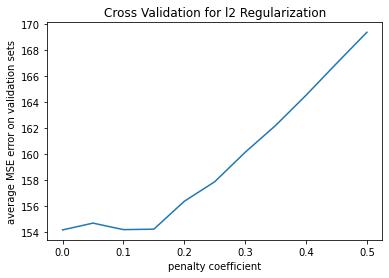

The best penalty coefficient is 0.0


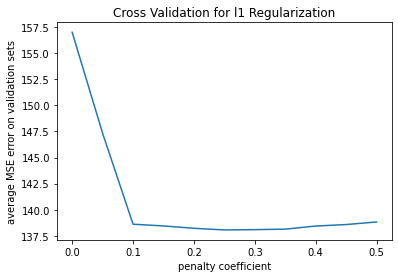

The best penalty coefficient is 0.25


(                       MSE       R^2     SPO Loss  SPO Loss Ave
 mse_ols   train  57.973550  0.764021  2050.467801     10.355898
           test   65.606419  0.594760   644.175032     11.301316
 mse_ridge train  57.986711  0.763968  2050.759253     10.357370
           test   65.489309  0.595484   643.353904     11.286911
 mse_lasso train  60.102118  0.755357  2045.257417     10.329583
           test   60.335007  0.627321   596.302378     10.461445,
                         MSE       R^2     SPO Loss  SPO Loss Ave
 spo_ols   train  149.491143  0.391504  1089.420096      5.502122
           test    98.516521  0.391480   404.831728      7.102311
 spo_ridge train  149.174853  0.392791  1089.586291      5.502961
           test    98.727876  0.390175   405.311663      7.110731
 spo_lasso train  149.643701  0.390883  1089.579524      5.502927
           test    98.670593  0.390529   404.339263      7.093671)

In [24]:
x_train, y_train, x_test, y_test = preprocessing(order_dict[1])
model_pipeline(x_train, y_train, x_test, y_test)

In [ ]:
x_train, y_train, x_test, y_test = preprocessing(order_dict[1])
model_pipeline(x_train, y_train, x_test, y_test)

In [32]:
final_results = dict()

In [35]:
for dc_i in order_dict.keys():
    x_train, y_train, x_test, y_test = preprocessing(order_dict[dc_i])
    MSE_i, SPO_i = model_pipeline(x_train, y_train, x_test, y_test)
    final_results[dc_i] = {'MSE result': MSE_i, 'SPO result': SPO_i}
    print(str(dc_i)+' done.')

1 done.
2 done.
3 done.
4 done.
5 done.
6 done.
7 done.
8 done.
9 done.
10 done.
11 done.
12 done.
13 done.
14 done.
15 done.
16 done.
17 done.
18 done.
19 done.
20 done.
21 done.
22 done.
23 done.
24 done.
25 done.
26 done.
27 done.
28 done.
29 done.
30 done.
31 done.
32 done.
33 done.
34 done.
35 done.
36 done.
37 done.
38 done.
39 done.
40 done.
41 done.
42 done.
43 done.
44 done.
45 done.
46 done.
47 done.
48 done.
49 done.
50 done.
51 done.
52 done.
53 done.
54 done.
55 done.
60 done.
61 done.
62 done.
64 done.
67 done.


In [38]:
final_results.values()

dict_values([{'MSE result':                        MSE       R^2     SPO Loss  SPO Loss Ave
mse_ols   train  57.967809  0.764045  2050.622227     10.356678
          test   65.624006  0.594652   644.375270     11.304829
mse_ridge train  60.253760  0.754740  1925.947224      9.727006
          test   61.553501  0.619795   577.760973     10.136157
mse_lasso train  60.103433  0.755352  2045.648604     10.331559
          test   60.268742  0.627730   595.920618     10.454748, 'SPO result':                         MSE       R^2     SPO Loss  SPO Loss Ave
spo_ols   train  148.938473  0.393753  1089.376335      5.501901
          test    98.641693  0.390707   404.980823      7.104927
spo_ridge train  149.506349  0.391442  1089.250094      5.501263
          test    98.686273  0.390432   404.573871      7.097787
spo_lasso train  149.410933  0.391830  1089.651600      5.503291
          test    98.578287  0.391099   404.565691      7.097644}, {'MSE result':                           MSE       R

In [84]:
%%script echo skipping

final_results_json = {int(k): {k2: v2.to_dict() for k2, v2 in v.items()} for k, v in final_results.items()}
final_results_json2 = {int(k): {k2: {k3: {'_'.join(k4):v4 for k4, v4 in v3.items()} 
                                     for k3, v3 in v2.items()} 
                                for k2, v2 in v.items()}  
                       for k, v in final_results.items()}

import json
with open('final_results_woCapacity.json','w') as f:
    #json.dump(final_results_json2, f)

skipping


In [108]:
MSE_columns, MSE_index = final_results[1]['MSE result'].columns, final_results[1]['MSE result'].index
SPO_columns, SPO_index = final_results[1]['SPO result'].columns, final_results[1]['SPO result'].index

In [107]:
final_mse_ave = sum([results['MSE result'].to_numpy() for results in final_results.values()])/len(final_results)

pd.DataFrame(final_mse_ave, columns = MSE_columns, index = MSE_index)

MSE       R^2     SPO Loss  SPO Loss Ave
mse_ols   train  1514.578093  0.689001  5987.273697     26.847033
          test   1867.560528  0.522177  2021.409009     31.572347
mse_ridge train  1584.023035  0.675393  5824.272710     26.026088
          test   1849.054590  0.544576  1965.992855     30.619141
mse_lasso train  1523.334130  0.676506  5949.071413     26.670181
          test   1844.575500  0.562963  1980.696795     30.871034

In [109]:
final_spo_ave = sum([results['SPO result'].to_numpy() for results in final_results.values()])/len(final_results)

pd.DataFrame(final_spo_ave, columns = SPO_columns, index = SPO_index)

MSE       R^2     SPO Loss  SPO Loss Ave
spo_ols   train  7469.476809  0.203598  4751.803249     21.032477
          test   8224.956804  0.106897  1737.990730     26.960327
spo_ridge train  7482.107799  0.201307  4753.683237     21.040675
          test   8232.492639  0.104271  1739.359062     26.981850
spo_lasso train  7486.516399  0.201057  4754.006761     21.042142
          test   8242.035319  0.105148  1737.429957     26.948698

In [111]:
final_results[1]['SPO result'].loc[('spo_lasso','test'), 'SPO Loss Ave']

7.097643709207575

In [123]:
spo_loss_ave = {dc: results['SPO result'].loc[('spo_lasso','test'), 'SPO Loss Ave'] for dc, results in final_results.items()}
mse_loss_ave = {dc: results['MSE result'].loc[('mse_lasso','test'), 'SPO Loss Ave'] for dc, results in final_results.items()}

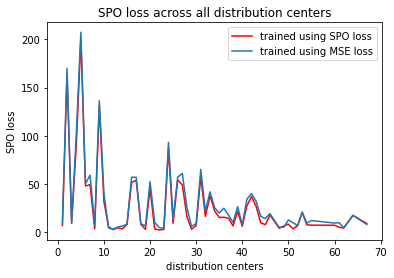

In [128]:
plt.plot(pd.Series(spo_loss_ave), color = 'red', label = 'trained using SPO loss')
plt.plot(pd.Series(mse_loss_ave), label = 'trained using MSE loss')
plt.ylabel('SPO loss')
plt.xlabel('distribution centers')
plt.legend(loc = 'upper right')
plt.title('SPO loss across all distribution centers')
plt.show()

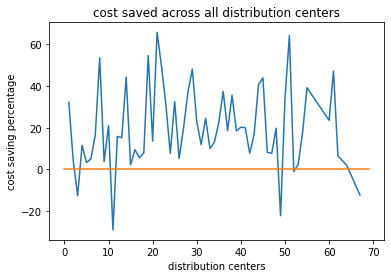

In [137]:
cost_saved_percent = (1- pd.Series(spo_loss_ave) / pd.Series(mse_loss_ave))*100
plt.plot(cost_saved_percent)
plt.ylabel('cost saving percentage')
plt.xlabel('distribution centers')
plt.title('cost saved across all distribution centers')
plt.plot(np.repeat(0,70))
plt.show()

In [138]:
cost_saved_percent

1     32.110808
2      4.124731
3    -12.589809
4     11.511063
5      3.252818
6      5.011413
7     16.531221
8     53.535931
9      3.744913
10    21.007735
11   -29.034441
12    15.803684
13    15.154709
14    44.272946
15     2.201507
16     9.451039
17     5.550798
18     7.982101
19    54.579005
20    13.556313
21    65.770015
22    49.629472
23    31.012964
24     7.668539
25    32.497084
26     5.219061
27    19.758569
28    37.013976
29    48.121067
30    22.970410
31    11.902061
32    24.478158
33     9.980393
34    13.073506
35    22.421562
36    37.374455
37    18.542088
38    35.582044
39    18.415045
40    20.236737
41    19.990010
42     7.739885
43    16.621435
44    40.614830
45    43.863095
46     8.144252
47     7.699476
48    19.761690
49   -22.219766
50    33.915362
51    64.256398
52    -1.063712
53     2.401044
54    17.833353
55    39.145375
60    23.527656
61    47.136032
62     6.486529
64     1.957424
67   -12.309229
dtype: float64

Ref:
Lineary Regression with Pytorch
  
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  
  https://www.reneshbedre.com/blog/pytorch-regression.html
  
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
  
Evaluations:

  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
  
Quick Ordinary Lineary Regression Calculator:

  https://www.socscistatistics.com/tests/regression/default.aspx
